In [2]:
import pandas as pd
import numpy as np
import requests
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [4]:
df = pd.read_csv("SeaPlaneTravel.csv")
df

,Month,#Passengers
0,2003-01,112
1,2003-02,118
2,2003-03,132
3,2003-04,129
4,2003-05,121
...,...,...
139,2015-08,606
140,2015-09,508
141,2015-10,461
142,2015-11,390


In [9]:
df['Month'] = pd.to_datetime(df['Month'])
idf = data.set_index('Month')
time_s = idf['#Passengers']
time_s

Month
2003-01    112
2003-02    118
2003-03    132
2003-04    129
2003-05    121
          ... 
2015-08    606
2015-09    508
2015-10    461
2015-11    390
2015-12    432
Name: #Passengers, Length: 144, dtype: int64

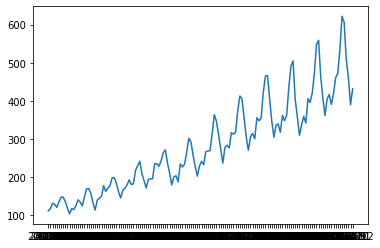

In [10]:
plt.plot(time_s)
plt.show()

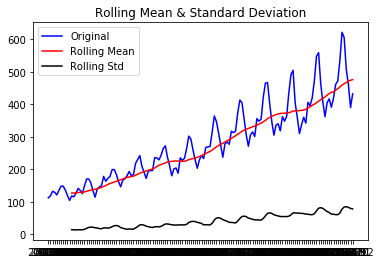

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [12]:
def test_stationarity(time_series):
    #Determing rolling statistics
    rmean = time_series.rolling(window=12,center=False).mean() 
    rstd = time_series.rolling(window=12,center=False).std()
    #Plot rolling statistics:
    orig = plt.plot(time_series, color='blue',label='Original')
    mean = plt.plot(rmean, color='red', label='Rolling Mean')
    std = plt.plot(rstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    df_test = adfuller(time_series, autolag='AIC')
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)

test_stationarity(time_s)

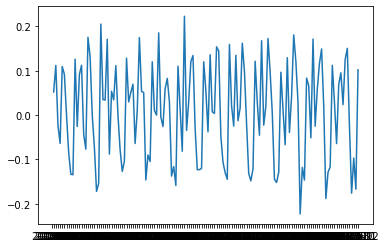

In [13]:
time_log = np.log(time_s)
time_log_diff = time_log - time_log.shift()
plt.plot(time_log_diff)


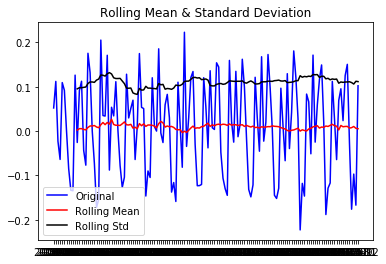

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [15]:
time_log_diff.dropna(inplace=True)
test_stationarity(time_log_diff)

In [16]:
acf = acf(time_log_diff, nlags=10)
pacf = pacf(time_log_diff, nlags=10, method='ols')

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Autocorrelation Function')

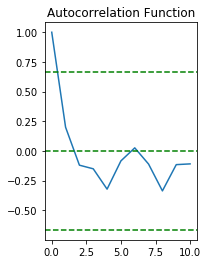

In [25]:
plt.subplot(121) 
plt.plot(acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-7.96/np.sqrt(len(time_log_diff)),linestyle='--',color='green')
plt.axhline(y=7.96/np.sqrt(len(time_log_diff)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

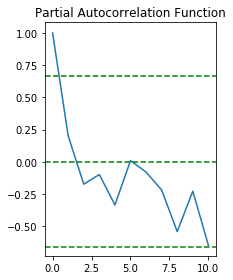

In [29]:
plt.subplot(121)
plt.plot(pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-7.96/np.sqrt(len(time_log_diff)),linestyle='--',color='green')
plt.axhline(y=7.96/np.sqrt(len(time_log_diff)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 1.1753')

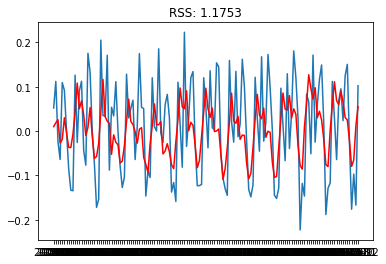

In [31]:
m = ARIMA(time_log, order=(2, 1, 1))  
results = m.fit(disp=-1)  
plt.plot(time_log_diff)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-time_log_diff)**2))

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 140.076
Method:                       css-mle   S.D. of innovations              0.090
Date:                Mon, 18 May 2020   AIC                           -270.151
Time:                        00:31:05   BIC                           -255.337
Sample:                             1   HQIC                          -264.131
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0101      0.000     23.509      0.000       0.009       0.011
ar.L1.D.#Passengers     0.9982      0.076     13.162      0.000       0.850       1.147
ar.L2.D.#Passeng

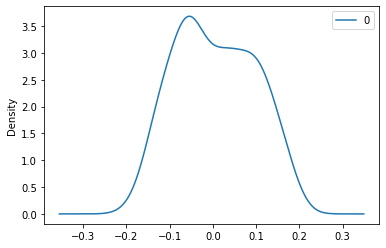

In [32]:
print(results.summary())
# plot 
residual = DataFrame(results.resid)
residual.plot(kind='kde')
print(residual.describe())

In [33]:
predict_ARIMA = pd.Series(results.fittedvalues, copy=True)
predict_ARIMA

Month
2003-02    0.010077
2003-03    0.018744
2003-04    0.025561
2003-05   -0.026625
2003-06   -0.019243
             ...   
2015-08   -0.021765
2015-09   -0.079855
2015-10   -0.065266
2015-11    0.011793
2015-12    0.055164
Length: 143, dtype: float64

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


Text(0.5, 1.0, 'RMSE: 192.7179')

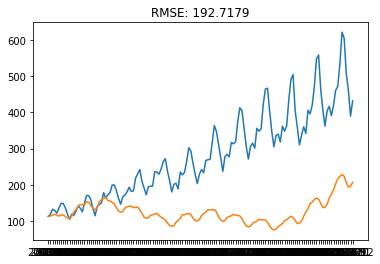

In [37]:
predictions_ARIMA_diff = predict_ARIMA.cumsum()
prediction_ARIMA = pd.Series(time_log.ix[0], index=time_log.index)
prediction_ARIMA = prediction_ARIMA.add(predictions_ARIMA_diff,fill_value=0)
predict_ARIMA1 = np.exp(prediction_ARIMA)
plt.plot(time_s)
plt.plot(predict_ARIMA1)
plt.title('RMSE: %.4f'% np.sqrt(sum((predict_ARIMA1-time_s)**2)/len(time_s)))

In [38]:
size = int(len(time_log) - 15)
train, test = time_log[0:size], time_log[size:len(time_log)]
hist = [x for x in train]
predict = list()

In [50]:
size = int(len(time_log) - 15)
train, test = time_log[0:size], time_log[size:len(time_log)]
hist = [x for x in train]
predict = list()
print('Printing Predicted vs Expected Values')
for t in range(len(test)):
    m = ARIMA(hist, order=(2,1,1))
    mfit = m.fit(disp=0)
    output = mfit.forecast()
    y_hat = output[0]
    predict.append(float(y_hat))
    o = test[t]
    hist.append(o)
print('predicted=%f, expected=%f' % (np.exp(y_hat), np.exp(o)))

Printing Predicted vs Expected Values
predicted=411.449176, expected=432.000000


In [51]:
error = mean_squared_error(test, predict)
print('Printing Mean Squared Error of Predictions')
print('Test MSE: %.6f' % error)
predict_series = pd.Series(predict, index = test.index)


Printing Mean Squared Error of Predictions
Test MSE: 0.008353


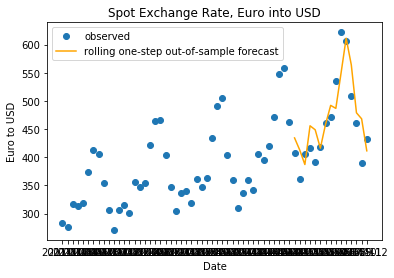

In [58]:
fig, ax = plt.subplots()
ax.set(title='Spot Exchange Rate, Euro into USD', xlabel='Date', ylabel='Euro to USD')
ax.plot(time_s[-60:], 'o', label='observed')
ax.plot(np.exp(predict_series), 'orange', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')